<font size="2"> To install new library (since everything is running on kernel python3.10): 
/$ python3.10 -m pip install *pandas*
</font>

In [1]:
# import all files from necessary directory
from os import listdir
import os
from os.path import isfile, join
dir = "/data/Riabova/train3"
all_files = [join(dir, f) for f in listdir(dir)]
all_files_mhd = [string for string in all_files if string.endswith("mhd")]
len(all_files_mhd)

288

In [2]:
import numpy as np

''' 
Example usage:
    coords_1 = [x1, x2, x3]  # Replace x1, x2, x3 with the actual values
    method = "hex2us"  # Or "us2hex"
    isShifted = True  # Or False
    coords_2 = transformTo(coords_1, method, isShifted) 

'''

def transformTo(coords_1, method, isShifted):
    # Transformation matrices
    T_needle_tip = np.array([[-0.1601, 3.1823, 0.1383, 13.8778],
                            [0.0178, 0.0806, -3.3695, 112.5630],
                            [-2.4504, -0.1146, -0.3139, 110.3655],
                            [-0.0000, -0.0000, -0.0000, 1.0000]])

    T_needle_tip_shifted = np.array([[-0.1601, 3.1823, 0.1383, 20.8778],
                                     [0.0178, 0.0806, -3.3695, 109.5630],
                                     [-2.4504, -0.1146, -0.3139, 110.3655],
                                     [-0.0000, -0.0000, -0.0000, 1.0000]])

    if isShifted:
        T = T_needle_tip_shifted
    else:
        T = T_needle_tip

    coords_1 = np.append(coords_1, 1)  # Add 1 to coords_1

    if method == "hex2us":
        coords_2 = np.dot(T, coords_1.T)
    else:
        coords_2 = np.linalg.solve(T, coords_1.T)  # Equivalent to inv(T) * coords_1.T

    coords_2 = coords_2.T
    coords_2 = coords_2[:-1]

    return coords_2


def transformToUS(coords_1):
    return transformTo(coords_1, "hex2us", True)

In [3]:
import numpy as np

def get_labels(f, info):
    
    labels = np.zeros((info['Dimensions'][3], 3))
        
    for frame in range(0, info['Dimensions'][3]):
        if frame > 9:
            info_frame_timestamp_field = "Seq_Frame00" + str(frame) + "_Timestamp"
        else:
            info_frame_timestamp_field = "Seq_Frame000" + str(frame) + "_Timestamp"
            
        frame_timestamp = float(info[info_frame_timestamp_field])
        
        # filename in format 'x_y_z_alpha_beta_gamma_velocity_axis_timestamp
        filename = f.split("/")[-1].split(".")[0] # 0_22_5_0_0_0_3_1_1686308127391259
        frame_timestamp_micros = frame_timestamp*1000000 #in microseconds, correct
        
         # extract params from filename
        filename_params = filename.split('_')
        start_timestamp_micros = float(filename_params[-1]) # in micros
        axis = int(filename_params[-2])
        velocity = int(filename_params[-3])  # in mm/s

        # get tip coords in hexapode system
        dt = frame_timestamp_micros - start_timestamp_micros  # in micros
        distance = velocity * dt / 1000000  # in mm
        hex_coords = [0, 0, 0]
        for i in range(3):
            hex_coords[i] = float(filename_params[i])
            if axis == i+1:
                hex_coords[i] += distance
                        
        # get tip coords in US system
        labels[frame, :] = transformToUS(hex_coords)
        
    return labels

In [4]:
from utils.type_reader import mha_read_header
import numpy as np
from tqdm import tqdm

# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
labels = np.empty((1, 3))
i = 0
for f in all_files_mhd:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    info = mha_read_header(f)
    labels = np.concatenate((labels, get_labels(f, info)), axis = 0)
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*info['Dimensions'][3]), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, info['Dimensions'][3])), axis=0)
    i+=1
    
all_frames_filenames_array = all_frames_filenames_array[ 1:]
labels = labels[1:, :]
frame_nums = frame_nums[1:]

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...
File 120...
File 140...
File 160...
File 180...
File 200...
File 220...
File 240...
File 260...
File 280...


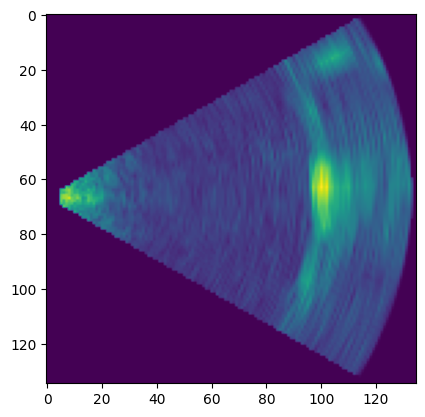

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
from utils.type_reader import get_image_array

#Check that frames are being displayed correctly
input_image = get_image_array(all_files_mhd[0])
plt.imshow(input_image[:, :, 69, 3])

In [6]:
X = np.vstack((all_frames_filenames_array, frame_nums)).transpose()
y = labels
print(X.shape)
print(X[0, :])
print(y[0, :])

(17717, 2)
['/data/Riabova/train3/0_22_5_0_0_0_3_1_1686308127391259.mhd' '0.0']
[ 91.57465921  94.48928267 106.19458738]


<font size="4">Setting parameters:</font>

In [7]:
SPLIT_PERCENT = 0.2
IMG_SIZE = 135
# init number of epochs to train for, and the
# batch size of train and validation sets
EPOCHS = 20
BATCH_TRAIN = 2
BATCH_VALID = 2
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CLASSES = 2
NUM_LEVELS = 3
# initialize learning rate, weight decay and momentum for adam
INIT_LR = 0.001
WEIGHT_DECAY = 1e-8
MOMENTUM = 0.999
# define threshold to filter weak predictions
THRESHOLD = 0.5

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X[:50, :], y[:50, :], test_size=SPLIT_PERCENT, random_state=42,shuffle=True)

In [12]:
y_train.shape

(40, 3)

In [13]:
from utils.ImageDataset import ImageDataset
import torch

train_dataset = ImageDataset(X_train,y_train)
valid_dataset = ImageDataset(X_valid,y_valid)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_TRAIN,shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_VALID,shuffle=True)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [16]:
from utils.display_utils import show_sample
#show_sample(train_dataset[0])

In [17]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
# this cell is intended just to check dimensions:
for (i, sample_batched) in enumerate(train_dataloader):
    x = sample_batched['image']
    y = sample_batched['mask']
    print(x.shape)
    print(y.shape)
    break

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])


In [19]:
import argparse
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from model.unet.unet import UNet
import wandb

model = UNet(1, 2)
optimizer = optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
criterion = nn.CrossEntropyLoss()
global_step = 0

In [20]:
import numpy as np
import torch


class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, sample_batched in batch_iter:
            input, target = sample_batched['image'].to(self.device), sample_batched['mask'].to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            print(out.shape)
            out = out[:, np.newaxis, :, :, :]
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, sample_batched in batch_iter:
            input, target = sample_batched['image'].to(self.device), sample_batched['label'].to(self.device)   # send to device (GPU or CPU)

            
            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

In [21]:
sample_batched = next(iter(train_dataloader))   

In [22]:
# trainer

trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_dataloader,
                  validation_DataLoader=valid_dataloader,
                  lr_scheduler=None,
                  epochs=2,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: Expected target size [2, 128, 128, 128], got [2, 1, 128, 128, 128]